In [1]:
# conda activate aso_design
import sys
from pathlib import Path

p = Path.cwd()
while p != p.parent and not (p / "pyproject.toml").exists():
    p = p.parent

sys.path.insert(0, str(p))
print("Project root:", p)



import pandas as pd
from notebooks.consts import *
from tauso.file_utils import read_human_genome_fasta_dict
from tauso.consts import *
import numpy as np
from tauso.util import get_antisense
import pickle
from tauso.genome.read_human_genome import get_locus_to_data_dict
from tauso.file_utils import read_human_genome_fasta_dict
import RNA

Project root: /home/nivd1/TAUSO


In [2]:
csv_path = NOTEBOOK_PATH / 'data' / 'data_asoptimizer_updated.csv'
all_data = pd.read_csv(str(csv_path), low_memory=False)

Preprocessing ASO Experimental Dataset

In [3]:
from notebooks.notebook_utils import log_correction

# Remove rows with missing values in the INHIBITION column
all_data_no_nan = all_data.dropna(subset=[INHIBITION]).copy()
# Create a new column with transformed inhibition values on a negative log scale
log_correction(all_data_no_nan) # to avoid log 0

In [4]:
# Filter the data to include only rows where the cell line organism is human
all_data_no_nan_human = all_data_no_nan[all_data_no_nan[CELL_LINE_ORGANISM] == 'human']
genes = all_data_no_nan[CANONICAL_GENE].copy()
genes_u = list(set(genes))
# Remove non-human or negative controls from the gene list
genes_u.remove('HBV')
genes_u.remove('negative_control')

In [5]:
from notebooks.notebook_utils import read_cached_gene_to_data

gene_to_data = read_cached_gene_to_data(genes_u)

In [6]:
# Filter data to keep only rows with valid gene information
all_data_human_gene = all_data_no_nan_human[all_data_no_nan_human[CANONICAL_GENE].isin(genes_u)].copy()

# Define names for new columns
SENSE_SEQUENCE = 'sense_sequence'
PRE_MRNA_SEQUENCE = 'pre_mrna_sequence'
SENSE_START = 'sense_start'
SENSE_LENGTH = 'sense_length'

# Initialize new columns
all_data_human_gene[SENSE_SEQUENCE] = ""
all_data_human_gene[PRE_MRNA_SEQUENCE] = ""
all_data_human_gene[SENSE_START] = np.zeros_like(all_data_human_gene[CANONICAL_GENE], dtype=int)
all_data_human_gene[SENSE_LENGTH] = np.zeros_like(all_data_human_gene[CANONICAL_GENE], dtype=int)

# Iterate over each row and compute the antisense complement and the gene's pre-mRNA
for index, row in all_data_human_gene.iterrows():
    gene_name = row[CANONICAL_GENE]

    if gene_name not in gene_to_data:
        continue  # Skip genes not found in genome annotation

    locus_info = gene_to_data[gene_name]
    pre_mrna = locus_info.full_mrna
    antisense = row[SEQUENCE]
    sense = get_antisense(antisense)
    idx = pre_mrna.find(sense)

    # Store computed sequences in new columns
    all_data_human_gene.loc[index, SENSE_START] = idx
    all_data_human_gene.loc[index, SENSE_LENGTH] = len(antisense)
    all_data_human_gene.at[index, SENSE_SEQUENCE] = sense
    all_data_human_gene.at[index, PRE_MRNA_SEQUENCE] = pre_mrna

In [7]:
all_data_human_gene.columns

Index(['index', 'ISIS', 'Target_gene', 'Cell_line', 'Density(cells/well)',
       'Transfection', 'ASO_volume(nM)', 'Treatment_Period(hours)',
       'Primer_probe_set', 'Sequence', 'Modification', 'Location',
       'Chemical_Pattern', 'Linkage', 'Linkage_Location', 'Smiles',
       'Inhibition(%)', 'seq_length', 'Canonical Gene Name',
       'Cell line organism', 'Transcript', 'Location_in_sequence',
       'Location_div_by_length', 'true_length_of_seq', 'mod_scan',
       'cell_line_uniform', 'log_inhibition', 'sense_sequence',
       'pre_mrna_sequence', 'sense_start', 'sense_length'],
      dtype='object')

In [8]:
all_data_human_gene.head()

,index,ISIS,Target_gene,Cell_line,Density(cells/well),Transfection,ASO_volume(nM),Treatment_Period(hours),Primer_probe_set,Sequence,...,Location_in_sequence,Location_div_by_length,true_length_of_seq,mod_scan,cell_line_uniform,log_inhibition,sense_sequence,pre_mrna_sequence,sense_start,sense_length
0,0,540733,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GCTAAAACAAATGCTA,...,41212.0,0.901972,16,0,A431,-4.204842,TAGCATTTGTTTTAGC,GATTTTCCTAGGCGGCGGCCGCGGCGGCGGAGGCAGCAGCGGCGGC...,41212,16
1,1,540747,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,TATAATGGTGAATATC,...,23686.0,0.518395,16,0,A431,-4.532707,GATATTCACCATTATA,GATTTTCCTAGGCGGCGGCCGCGGCGGCGGAGGCAGCAGCGGCGGC...,23686,16
2,2,540806,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GCATGAAGATTTCTGG,...,43363.0,0.949049,16,1,A431,-3.637849,CCAGAAATCTTCATGC,GATTTTCCTAGGCGGCGGCCGCGGCGGCGGAGGCAGCAGCGGCGGC...,43363,16
3,3,651479,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GGTGAATATCTTCAAA,...,23680.0,0.518264,16,0,A431,-4.276805,TTTGAAGATATTCACC,GATTTTCCTAGGCGGCGGCCGCGGCGGCGGAGGCAGCAGCGGCGGC...,23680,16
4,4,651490,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,CACTTGTACTAGTATG,...,41168.0,0.901009,16,0,A431,-4.159039,CATACTAGTACAAGTG,GATTTTCCTAGGCGGCGGCCGCGGCGGCGGAGGCAGCAGCGGCGGC...,41168,16


generate modification features

In [9]:
# compute_mod_fraction
from src.tauso.features.mod_features import compute_mod_fraction

all_data_human_gene['Modification_fraction'] = all_data_human_gene["Chemical_Pattern"].apply(lambda x: compute_mod_fraction(x))
modification_features = ['Modification_fraction']

In [10]:
# compute_mod_type_count
from src.tauso.features.mod_features import compute_mod_type_count

all_data_human_gene['Modification_type_count'] = all_data_human_gene["Chemical_Pattern"].apply(lambda x: compute_mod_type_count(x))
modification_features.append('Modification_type_count')

In [11]:
# compute_mod_5prime_run
from src.tauso.features.mod_features import compute_mod_5prime_run

all_data_human_gene['Modification_5prime_run'] = all_data_human_gene["Chemical_Pattern"].apply(lambda x: compute_mod_5prime_run(x))
modification_features.append('Modification_5prime_run')

In [12]:
# compute_mod_3prime_run
from src.tauso.features.mod_features import compute_mod_3prime_run

all_data_human_gene['Modification_3prime_run'] = all_data_human_gene["Chemical_Pattern"].apply(lambda x: compute_mod_3prime_run(x))
modification_features.append('Modification_3prime_run')

In [13]:
#compute_mod_min_distance_to_5prime
from src.tauso.features.mod_features import compute_mod_min_distance_to_5prime

all_data_human_gene['Modification_min_distance_to_5prime'] = all_data_human_gene["Chemical_Pattern"].apply(lambda x: compute_mod_min_distance_to_5prime(x))
modification_features.append('Modification_min_distance_to_5prime')

In [14]:
#compute_mod_min_distance_to_3prime
from src.tauso.features.mod_features import compute_mod_min_distance_to_3prime

all_data_human_gene['Modification_min_distance_to_3prime'] = all_data_human_gene["Chemical_Pattern"].apply(lambda x: compute_mod_min_distance_to_3prime(x))
modification_features.append('Modification_min_distance_to_3prime')

In [15]:
#compute_mod_pos_std
from src.tauso.features.mod_features import compute_mod_pos_std

all_data_human_gene['Modification_pos_std'] = all_data_human_gene["Chemical_Pattern"].apply(lambda x: compute_mod_pos_std(x))
modification_features.append('Modification_pos_std')

In [16]:
#compute_mod_block_count
from src.tauso.features.mod_features import compute_mod_block_count

all_data_human_gene['Modification_block_count'] = all_data_human_gene["Chemical_Pattern"].apply(lambda x: compute_mod_block_count(x))
modification_features.append('Modification_block_count')

In [17]:
#compute_mod_max_block_length
from src.tauso.features.mod_features import compute_mod_max_block_length

all_data_human_gene['Modification_max_block_length'] = all_data_human_gene["Chemical_Pattern"].apply(lambda x: compute_mod_max_block_length(x))
modification_features.append('Modification_max_block_length')

In [18]:
#compute_mod_char_entropy
from src.tauso.features.mod_features import compute_mod_char_entropy

all_data_human_gene['Modification_char_entropy'] = all_data_human_gene["Chemical_Pattern"].apply(lambda x: compute_mod_char_entropy(x))
modification_features.append('Modification_char_entropy')

In [19]:
#compute_dominant_mod_fraction
from src.tauso.features.mod_features import compute_dominant_mod_fraction

all_data_human_gene['Modification_dominant_mod_fraction'] = all_data_human_gene["Chemical_Pattern"].apply(lambda x: compute_dominant_mod_fraction(x))
modification_features.append('Modification_dominant_mod_fraction')

In [20]:
#compute_mod_evenness
from src.tauso.features.mod_features import compute_mod_evenness

all_data_human_gene['Modification_evenness'] = all_data_human_gene["Chemical_Pattern"].apply(lambda x: compute_mod_evenness(x))
modification_features.append('Modification_evenness')

In [21]:
#compute_mod_symmetry_score
from src.tauso.features.mod_features import compute_mod_symmetry_score

all_data_human_gene['Modification_symmetry_score'] = all_data_human_gene["Chemical_Pattern"].apply(lambda x: compute_mod_symmetry_score(x))
modification_features.append('Modification_symmetry_score')

In [22]:
#compute_mod_skew_index
from src.tauso.features.mod_features import compute_mod_skew_index

all_data_human_gene['Modification_skew_index'] = all_data_human_gene["Chemical_Pattern"].apply(lambda x: compute_mod_skew_index(x))
modification_features.append('Modification_skew_index')

In [23]:
#compute_mod_mean_gap
from src.tauso.features.mod_features import compute_mod_mean_gap

all_data_human_gene['Modification_mean_gap'] = all_data_human_gene["Chemical_Pattern"].apply(lambda x: compute_mod_mean_gap(x))
modification_features.append('Modification_mean_gap')

In [24]:
#compute_mod_local_density_max
from src.tauso.features.mod_features import compute_mod_local_density_max

all_data_human_gene['Modification_local_density_max'] = all_data_human_gene["Chemical_Pattern"].apply(lambda x: compute_mod_local_density_max(x))
modification_features.append('Modification_local_density_max')

In [25]:
#compute_mod_in_core
from src.tauso.features.mod_features import compute_mod_in_core

all_data_human_gene['Modification_in_core'] = all_data_human_gene["Chemical_Pattern"].apply(lambda x: compute_mod_in_core(x))
modification_features.append('Modification_in_core')

In [26]:
#compute_mod_longest_repeat_run
from src.tauso.features.mod_features import compute_mod_longest_repeat_run

all_data_human_gene['Modification_longest_repeat_run'] = all_data_human_gene["Chemical_Pattern"].apply(lambda x: compute_mod_longest_repeat_run(x))
modification_features.append('Modification_longest_repeat_run')

In [27]:
#compute_mod_adjacent_pair_count
from src.tauso.features.mod_features import compute_mod_adjacent_pair_count

all_data_human_gene['Modification_adjacent_pair_count'] = all_data_human_gene["Chemical_Pattern"].apply(lambda x: compute_mod_adjacent_pair_count(x))
modification_features.append('Modification_adjacent_pair_count')

In [28]:
#compute_mod_strong_repeat_group_count
from src.tauso.features.mod_features import compute_mod_strong_repeat_group_count

all_data_human_gene['Modification_strong_repeat_group_count'] = all_data_human_gene["Chemical_Pattern"].apply(lambda x: compute_mod_strong_repeat_group_count(x))
modification_features.append('Modification_strong_repeat_group_count')

In [29]:
from notebooks.features.RNaseH.correlation_test import analyze_feature_correlations
results_df = analyze_feature_correlations(all_data_human_gene, target='log_inhibition')
display(results_df)



,Feature,Pearson,Spearman,NMI_max
16,Inhibition(%),0.891,1.000,2.058
1,ISIS,-0.092,-0.145,0.154
0,index,0.317,0.301,0.114
21,Location_in_sequence,-0.013,0.223,0.107
28,sense_start,-0.018,0.219,0.107
6,ASO_volume(nM),0.288,0.296,0.092
36,Modification_pos_std,-0.214,-0.162,0.055
44,Modification_mean_gap,-0.266,-0.250,0.048
22,Location_div_by_length,0.084,0.129,0.045
30,Modification_fraction,0.175,0.186,0.036


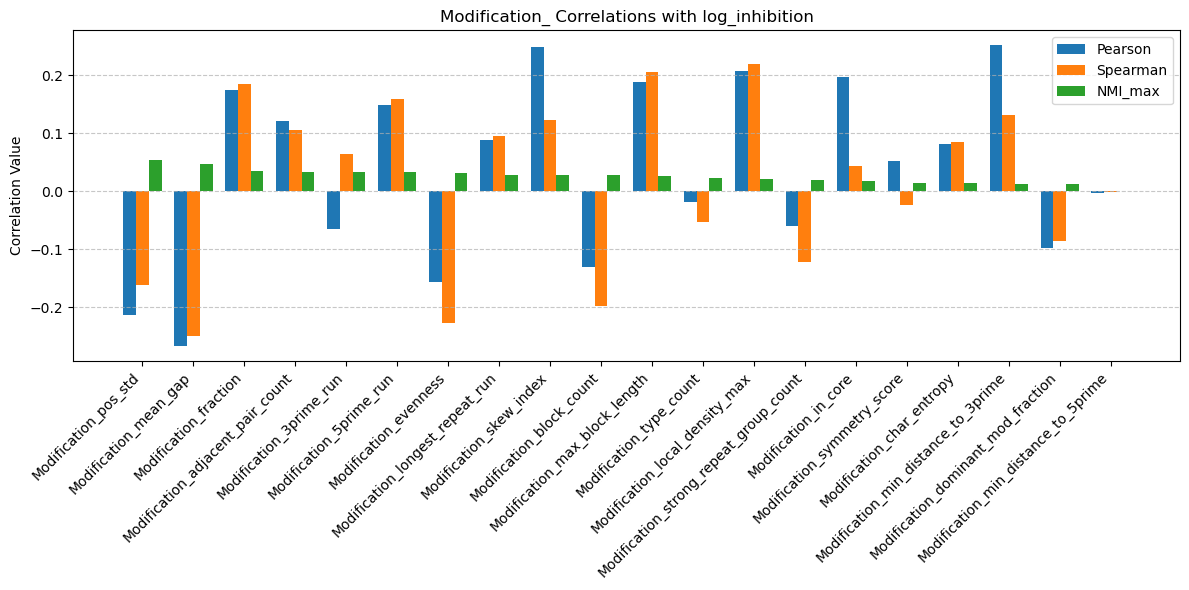

In [30]:
from notebooks.features.RNaseH.correlation_test import plot_feature_correlations_by_prefix
plot_feature_correlations_by_prefix(results_df, prefix='Modification_', title='Modification_ Correlations with log_inhibition')

In [31]:
from notebooks.features.feature_extraction import save_feature
for feature in modification_features:
    save_feature(all_data_human_gene, feature_name=feature)